## MNIST tensorflow Machine Learning note

    MNIST is a canonical dataset for machine learning test. 

### Import modules ,load MNIST dataset and start interactive session 

In [134]:
#load MNIST data
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import animation
from numpy.random import RandomState

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

#mnist ia a lightweight class , includes training validation and testing dataset in umpy array mode

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [135]:
#convenient when working with interactive contexts like ipython
sess = tf.InteractiveSession()

In [164]:
x = tf.placeholder(tf.float32, shape=[None, 784])  #MNIST 28x28 pixels 
y_ = tf.placeholder(tf.float32, shape=[None, 10])  #10 dimentional verctor indicates real digit 1-10

In [165]:
#initial Weight and bias by filling of zeros
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())
print W.eval()
print b.eval()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### Build a Softmax Regression Model
    Simply we can call it no hidden layer network 

In [166]:
#define regression model
y = tf.matmul(x,W) + b

In [167]:
#specify loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

In [168]:
#specify train model
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

step 0 corss_entropy 2.020794
step 50 corss_entropy 0.529039
step 100 corss_entropy 0.404912
step 150 corss_entropy 0.381642
step 200 corss_entropy 0.365754
step 250 corss_entropy 0.347816
step 300 corss_entropy 0.341887
step 350 corss_entropy 0.329071
step 400 corss_entropy 0.326172
step 450 corss_entropy 0.323355
step 500 corss_entropy 0.317942
step 550 corss_entropy 0.319675
step 600 corss_entropy 0.328030
step 650 corss_entropy 0.318455
step 700 corss_entropy 0.305990
step 750 corss_entropy 0.304117
step 800 corss_entropy 0.305624
step 850 corss_entropy 0.298308
step 900 corss_entropy 0.305628
step 950 corss_entropy 0.298876
step 1000 corss_entropy 0.292583


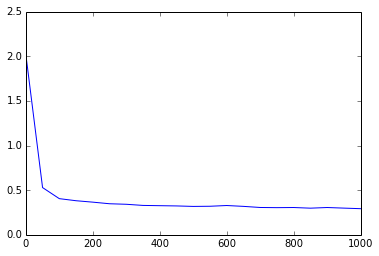

In [169]:
px = []
py = []
for i in range(1001):
  
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})
  if i%50 == 0:
    c_ep=cross_entropy.eval(feed_dict={x: mnist.train.images,y_: mnist.train.labels})
    print("step %d corss_entropy %f"% (i,c_ep))
    px.append(i)
    py.append(c_ep)

%matplotlib inline
plt.plot(px,py)

In [170]:
print W.eval()
print b.eval()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[-0.37697944  0.33022499  0.08318686 -0.2426587   0.02532654  1.33719277
 -0.11185047  0.63854933 -1.45174158 -0.23124941]


In [171]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [172]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [173]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
# .eval means this is an interactive session 
print(correct_prediction.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
#some of the result is False  , so the prediction accuracy is around 91.x% 
#is a BAD accuracy

0.9185
[ True  True  True ...,  True  True  True]


### Build a Multilayer Convolutional Network
    Multilayers netowrks can compose more features and make A better  prediction accuracy .
    
    MNIST iamge input 28x28x1 
    1st convolutional layer , 28x28x32 (filter size 5x5 stride [1,1] output deepth 32)
    1st pooling layer ,14x14x32 (filter size 2x2 stride [2,2])
    2nd convolutional layer , 14x14x64 (filter 5x5 stide 1,1 output deepth 64)
    2nd pooling layer ,7x7x64 ,(filter same)
    2nd pooling flat = 7x7x64 = 3136   flat layer
    full connection layer = 1024 (after activation funvtion ReLu
    full connection layer dropout rate 0.5
    final_output flat layer = 10

In [188]:
#weights and biases initialization...
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [189]:
#define convolution and pooling function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')#usually ,pooling filter size 2x2 or 3x3 

In [190]:
'''
The convolution will compute 32 features for each 5x5 patch. 
Its weight tensor will have a shape of [5, 5, 1, 32]. 
The first two dimensions are the patch size, the next is the number of input channels,
and the last is the number of output channels

it means , the filter size is 5x5  , 
input layer has 2 dimensions, 28x28x1 (mono ,no RGB color channels ) ,1 as input layer deepth
and 32 is output deepth

for output convolutional layer width and length , 28-5+1=24 /1 = 24  (if filter stride = 1 )
output_length=[ (input_length-filter_length +1)/stride_length ] --->when padding is VALID 

In this case. padding = "SAME" , output_length = input_length/stride =28/1= 28

bias numbers = output layer deepth
'''
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [191]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # filter size 5x5 ,strides [1,1] , padding =VALID
h_pool1 = max_pool_2x2(h_conv1)

In [193]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [194]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [195]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [196]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [197]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 500 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


step 0, training accuracy 0.08
step 500, training accuracy 0.96
step 1000, training accuracy 0.94
step 1500, training accuracy 0.96
step 2000, training accuracy 0.98
step 2500, training accuracy 0.98
step 3000, training accuracy 1
step 3500, training accuracy 1
step 4000, training accuracy 1
step 4500, training accuracy 0.98
step 5000, training accuracy 0.98
step 5500, training accuracy 1
step 6000, training accuracy 1
step 6500, training accuracy 1
step 7000, training accuracy 1
step 7500, training accuracy 1
step 8000, training accuracy 1
step 8500, training accuracy 1
step 9000, training accuracy 1
step 9500, training accuracy 0.98
test accuracy 0.9904


    After 10000 steps trsaining , the test acurracy is 99% ,much better than a no hiddenlayer neural network .